In [1]:
import os
cwd = os.getcwd()
kaggle = cwd == "/kaggle/working"

In [2]:
from transformers import XLMRobertaTokenizerFast
import torch

tokenizer = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base')

In [3]:
import pandas as pd
import json

# Load the dataset
df = pd.read_csv('data/dataset.csv')
# df = pd.read_csv('data/dataset_old.csv')
from sklearn.model_selection import train_test_split
df, val = train_test_split(df, test_size=0.034, random_state=42)
print(df.shape, val.shape)

(2860, 3) (101, 3)


Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


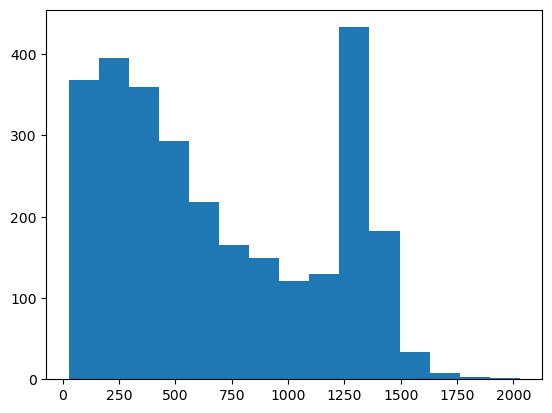

In [4]:
token_counts = []
max_length = 0
for row in df.iterrows():
    l = len(tokenizer.encode(row[1]['input']))
    token_counts.append(l)
    if l > max_length:
        max_length = l+10

# plot the token counts
import matplotlib.pyplot as plt
plt.hist(token_counts, bins=15)

modu = max_length % 256
max_length = max_length + 256 - modu

In [5]:


# Function to extract hardware mentions and their ownership status
def extract_hardware_info(row):
    hardware_info = json.loads(row['output'])
    # hardware_dict = {item['hardware_name'].lower(): item['hardware_is_owned'] for item in hardware_info}
    hardware_dict = {}
    for item in hardware_info:
        # if item is a string there is a problem
        if isinstance(item, str):
            print("error")
            print(item)
            continue
        if 'hardware_name' in item:
            hardware_name = item['hardware_name']
        else:
            print("error: no hardware_name found")
            print(item)
            continue
        if 'hardware_is_owned' in item:
            hardware_is_owned = item['hardware_is_owned']
        else:
            print("error: no hardware_is_owned found")
            print(item)
            continue
        hardware_dict[str(hardware_name)] = hardware_is_owned
    return hardware_dict

# Apply the function to each row
df['hardware_info'] = df.apply(extract_hardware_info, axis=1)
val['hardware_info'] = val.apply(extract_hardware_info, axis=1)

error: no hardware_name found
{'bi-metal thermostat': 'hardware_is_owned', 'hardware_is_owned': False}
error: no hardware_name found
{'PSU': 'hardware_is_owned', 'hardware_is_owned': True}
error: no hardware_name found
{'fan': 'hardware_is_owned', 'hardware_is_owned': True}
error: no hardware_name found
{'server power supplies': 'hardware_is_owned', 'hardware_is_owned': False}
error: no hardware_name found
{'IBM 2 or 2.8kw PSU': 'hardware_is_owned', 'hardware_is_owned': False}
error: no hardware_name found
{'GekkoScience breakouts': 'hardware_is_owned', 'hardware_is_owned': False}
error: no hardware_is_owned found
{'hardware_name': True}
error
error
error: no hardware_name found
{'S17 pro': {'hardware_name': 'S17 pro', 'hardware_is_owned': False}}
error: no hardware_is_owned found
{'hardware_name': False}
error: no hardware_is_owned found
{'hardware_name': False}
error
error
error: no hardware_name found
{'S17': {'hardware_name': 'S17', 'hardware_is_owned': True}}
error: no hardware_is

In [6]:
# Function to encode texts and labels
def encode_texts_and_labels(row):
    input_text = row['input']
    hardware_info = row['hardware_info']
    encoding = tokenizer(input_text, truncation=True, padding='max_length', max_length=max_length, return_tensors="pt")
    labels = [0] * encoding.input_ids.size(1)  # Initialize labels as 0 (not hardware or not owned)
    
    # Update labels for hardware mentions
    for word, owned in hardware_info.items():
        # if owned:
        #     print(word)
        word_ids = tokenizer.encode(word, add_special_tokens=False)
        for i in range(len(encoding.input_ids[0]) - len(word_ids) + 1):
            if encoding.input_ids[0][i:i+len(word_ids)].tolist() == word_ids:
                labels[i:i+len(word_ids)] = [2 if owned else 1] * len(word_ids)
    
    # for l in labels:
    #     if l == 1:
    #         print("yes")
    #         break
    encoding['labels'] = torch.tensor([labels])
    return encoding

# Apply the function to each row and collect encoded texts and labels
encoded_texts_and_labels = [encode_texts_and_labels(row) for _, row in df.iterrows()]
encoded_texts_and_labels_val = [encode_texts_and_labels(row) for _, row in val.iterrows()]

In [7]:
print(encoded_texts_and_labels[0]['input_ids'].shape)
print(encoded_texts_and_labels[0]['labels'].shape)
print(encoded_texts_and_labels[0]['attention_mask'].shape)
print(len(encoded_texts_and_labels))

torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
2860


In [8]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
from torch import save, load

In [9]:
def generate_colored_html(data):
    """Generate HTML string for colored text based on provided data."""
    
    def get_color(value):
        """Compute color for a given value"""
        # Convert the value to a value between 0 (for 0.4) and 1 (for 0.6)
        value = float(value)
        # value = np.clip(value, 0.4, 0.6)
        # normalized_value = (value - 0.4) / 0.2

        normalized_value = float(value)
        
        # Linearly interpolate between red (0) and green (1)
        red = 255 * (1 - normalized_value)
        green = 255 * normalized_value
        
        return f'rgb({int(red)}, {int(green)}, 0)'

    html_parts = []

    for text, value in data:
        color = get_color(value)
        html_parts.append(f'<span style="color: {color};font-weight: bold;">{text}</span>')

    return ''.join(html_parts)

In [10]:
# to verify correctness, let's display the first sample with tokens highlighted when label is 1
id = 1
for id in range(10):
    input_ids = encoded_texts_and_labels[id]['input_ids'][0]
    labels = encoded_texts_and_labels[id]['labels'][0]*0.5
    tokens = tokenizer.convert_ids_to_tokens(input_ids.numpy())
    arr = [(token, label) for token, label in zip(tokens, labels)]
    display(HTML(generate_colored_html(arr[1:])))

In [11]:
from torch.utils.data import Dataset, DataLoader

class HardwareDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        # return self.encodings[idx]
        return {
            'input_ids': self.encodings[idx]['input_ids'].flatten(),
            'labels': self.encodings[idx]['labels'].flatten(),
            'attention_mask': self.encodings[idx]['attention_mask'].flatten()
        }

    def __len__(self):
        return len(self.encodings)

# Create the dataset
train_dataset = HardwareDataset(encoded_texts_and_labels)
val_dataset = HardwareDataset(encoded_texts_and_labels_val)

In [12]:
import torch
from transformers import TrainingArguments, Trainer

# from longformer.longformer import Longformer, LongformerConfig
# from longformer.sliding_chunks import pad_to_window_size

from transformers import LongformerForTokenClassification, XLMRobertaTokenizerFast
model = LongformerForTokenClassification.from_pretrained('severinsimmler/xlm-roberta-longformer-base-16384', num_labels=3)
tokenizer = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base')
config = model.config
tokenizer.model_max_length = config.max_position_embeddings


Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at severinsimmler/xlm-roberta-longformer-base-16384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
model = model.to('cpu')
#only the last layer and the classifier should be trained
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
# for param in model.longformer.encoder.layer[-1].parameters():
#     param.requires_grad = True
# for param in model.longformer.encoder.layer[-2].parameters():
#     param.requires_grad = True
# for param in model.longformer.encoder.layer[-3].parameters():
#     param.requires_grad = True
    
for layer in model.longformer.encoder.layer[-8:]:
    for param in layer.parameters():
        param.requires_grad = True

In [14]:
from datasets import load_metric

def compute_metrics(p):
    metric = load_metric("accuracy")
    metric_f1 = load_metric("f1")
    accuracy = metric.compute(predictions=p.predictions.argmax(-1), references=p.label_ids)
    f1 = metric_f1.compute(predictions=p.predictions.argmax(-1), references=p.label_ids, average='macro')
    return {"accuracy": accuracy["accuracy"], "f1": f1}

from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import LambdaLR

class EpochBasedLRScheduler(LambdaLR):
    def __init__(self, optimizer, lr_per_epoch, len_train_loader, last_epoch=-1):
        self.lr_per_epoch = lr_per_epoch
        self.len_train_loader = len_train_loader
        super(EpochBasedLRScheduler, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, current_step: int):
        current_epoch = current_step // self.len_train_loader
        if current_epoch < len(self.lr_per_epoch):
            return self.lr_per_epoch[current_epoch] / self.base_lrs[0]
        return 1.0

    
from transformers import TrainerCallback, TrainerControl, TrainingArguments

class PrintLearningRateCallback(TrainerCallback):
    def on_epoch_end(self, args: TrainingArguments, state: TrainerControl, control: TrainerControl, **kwargs):
        lr = state.log_history[-1]['learning_rate']
        print(f"Learning rate at end of epoch {state.epoch}: {lr}")



optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7)
lr_per_epoch = [
    1e-5,
    # 1e-5,
    # 1e-5,
    # 1e-5,
    # 1e-5,
    # 1e-5,
    2e-6,
    # 2e-6,
    # 2e-6,
    # 1e-6,
    # 1e-6,
    # 1e-6,
]


class EpochAverageLossCallback(TrainerCallback):
    def __init__(self):
        self.cumulative_loss = 0.0
        self.batch_count = 0

    def on_train_begin(self, args, state, control, **kwargs):
        # Reset at the beginning of training
        self.cumulative_loss = 0.0
        self.batch_count = 0

    def on_step_end(self, args, state, control, **kwargs):
        # Accumulate losses and increment batch count after each step
        self.cumulative_loss += state.log_history[-1]['loss'] if state.log_history else 0
        self.batch_count += 1

    def on_epoch_end(self, args, state, control, **kwargs):
        # Compute average loss and print it
        average_epoch_loss = self.cumulative_loss / self.batch_count
        print(f"Average training loss over epoch {state.epoch}: {average_epoch_loss:.4f}")

        # Reset for next epoch
        self.cumulative_loss = 0.0
        self.batch_count = 0


retrain = True
# retrain = False

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=len(lr_per_epoch),
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=0,
    weight_decay=0.01,
    logging_steps=len(train_dataset) // 4,
    #lr_scheduler_type='constant',
    #learning_rate=1e-9,
    report_to='none',
    evaluation_strategy='epoch',
)

len_train_loader = len(train_dataset) // training_args.per_device_train_batch_size
scheduler = EpochBasedLRScheduler(optimizer, lr_per_epoch, len_train_loader)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler),
    # callbacks=[PrintLearningRateCallback(), EpochAverageLossCallback()]
)

if retrain:
    model.train()
    trainer.train()
    torch.save(model, '/kaggle/working/model.pt' if kaggle else 'bert.pt')
    model.eval()
else:
    model = torch.load('/kaggle/working/model.pt' if kaggle else 'bert.pt')
    model.eval()


Epoch,Training Loss,Validation Loss
1,0.081400,0.026701
2,0.024700,0.024375
3,0.021800,0.024706


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


In [15]:
# visualize the model's predictions
model = model.to('cpu')
ds = val_dataset
# ds = train_dataset
# id = 0
for id in range(10):
    with torch.no_grad():
        input_ids = ds[id]['input_ids'].unsqueeze(0)
        attention_mask = ds[id]['attention_mask'].unsqueeze(0)
        labels = ds[id]['labels'].unsqueeze(0)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        # print(logits.shape)

        predictions = torch.argmax(logits, dim=-1)
        import torch.nn.functional as F
        predictions = F.sigmoid(logits)[0,:,2].numpy()
        print(predictions.shape)
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        predictions = scaler.fit_transform(predictions.reshape(-1, 1)).reshape(-1)
        print(predictions.min(), predictions.max())


        tokens = tokenizer.convert_ids_to_tokens(input_ids[0].numpy())
        arr = [(token, label) for token, label in zip(tokens, predictions)]
        display(HTML(generate_colored_html(arr[1:])))



(2048,)
0.0 1.0


(2048,)
0.0 1.0


(2048,)
0.0 1.0000001


(2048,)
0.0 1.0


(2048,)
0.0 1.0


(2048,)
0.0 1.0


(2048,)
0.0 1.0


(2048,)
0.0 1.0000001


(2048,)
0.0 0.99999994


(2048,)
0.0 1.0000001


In [16]:
# First, let's define a function to generate the HTML content for each sample
def generate_sample_html(sample_id, tokens, predictions, labels):
    html_content = f'<h1>Sample ID: {sample_id}</h1>\n'
    html_content += '<h3>Predictions</h3>\n'
    html_content += generate_colored_html([(token, pred) for token, pred in zip(tokens, predictions)][1:])
    html_content += '<h3>Labels</h3>\n'
    html_content += generate_colored_html([(token, label) for token, label in zip(tokens, labels)][1:])
    return html_content

# Now, let's iterate over the validation dataset and generate HTML for each sample
html_output = '<html>\n<head>\n<style>\n.container {width: 1000px; margin: auto;}\n</style>\n</head>\n<body>\n<div class="container">\n'

model = model.cuda()

for id in range(len(val_dataset)):
    with torch.no_grad():
        input_ids = val_dataset[id]['input_ids'].unsqueeze(0)
        attention_mask = val_dataset[id]['attention_mask'].unsqueeze(0)
        labels = val_dataset[id]['labels'].unsqueeze(0)
        outputs = model(input_ids=input_ids.cuda(), attention_mask=attention_mask.cuda())
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        predictions = F.sigmoid(logits)[0,:,2].cpu().numpy()
        # scaler = MinMaxScaler()
        # predictions = scaler.fit_transform(predictions.reshape(-1, 1)).reshape(-1)
        predictions *= 2 # Adjusting prediction values for visualization
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0].numpy())
        labels = labels[0].numpy() * 0.5  # Adjusting label values for visualization
        html_output += generate_sample_html(id, tokens, predictions, labels).replace("▁", " ").replace("###", "<br>###")
        html_output += '<hr>\n'
        if id == 50:
            break

html_output += '</div>\n</body>\n</html>'

# Finally, save the HTML content to a file
with open('validation_samples.html', 'w') as f:
    f.write(html_output)

print("HTML file 'validation_samples.html' has been created.")

HTML file 'validation_samples.html' has been created.
